# From PD to Pareto – Python demo 🐍

This notebook implements a small credit-portfolio optimisation demo:

- Synthetic credit segments with PD, LGD, base and stressed expected loss
- Linear programming with `cvxpy` to maximise expected return
- Constraints on:
  - base expected loss (EL),
  - stressed expected loss,
  - capital intensity (risk weights),
  - High-PD exposure,
  - country concentration.

We then:

1. Build an efficient frontier in **EL–Return** space.
2. Generate random feasible portfolios under the same constraints.
3. Compare random portfolios vs the efficient frontier and inspect extreme points.

In [1]:
"""
From PD to Pareto – Python demo (portfolio under EL, stress, capital and concentration constraints)

Synthetic credit portfolio + LP optimization with cvxpy
to trace an efficient frontier in Expected Loss vs Return space,
subject to:
- capital budget,
- stressed expected loss constraint,
- high-PD exposure limit,
- country concentration limits.
"""

import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 0. Global settings
# ------------------------------------------------------

np.random.seed(42)
N_SEGMENTS = 10

# How tight are the constraints?
STRESS_FACTOR = 2.5     # stressed EL must be <= STRESS_FACTOR * EL_cap
HIGH_PD_LIMIT = 0.40    # max share of exposure in "High" PD band
COUNTRY_LIMIT = 0.45    # max share of exposure in any single country
N_RANDOM = 1000         # random portfolios for comparison

## 1. Generate synthetic credit segments

We create a small synthetic universe of `N_SEGMENTS` credit segments.

For each segment we simulate:

- base PD between 0.5% and 5%
- LGD between 20% and 60%
- base expected loss `EL_base = PD_base × LGD`
- stressed PD and stressed EL (PD multiplied by a stress factor, capped at 20%)
- expected return increasing in `EL_base` (risk–return relationship) plus noise
- risk weights (proxy for capital intensity) between 30% and 120%
- a country label from `{Country_A, Country_B, Country_C}`
- a PD band (Low / Medium / High) based on base PD

In [2]:
# ------------------------------------------------------
# 1. Generate synthetic credit segments
# ------------------------------------------------------

segments = pd.DataFrame({
    "segment": [f"Seg_{i+1}" for i in range(N_SEGMENTS)],
    # base PD between 0.5% and 5%
    "PD_base": np.random.uniform(0.005, 0.05, size=N_SEGMENTS),
    # LGD between 20% and 60%
    "LGD": np.random.uniform(0.2, 0.6, size=N_SEGMENTS),
})

# unit EL in base scenario
segments["EL_base"] = segments["PD_base"] * segments["LGD"]

# stressed PD: base PD multiplied by a factor, capped at 20%
stress_mult = np.random.uniform(1.5, 3.0, size=N_SEGMENTS)
segments["PD_stress"] = np.minimum(0.20, segments["PD_base"] * stress_mult)
segments["EL_stress"] = segments["PD_stress"] * segments["LGD"]

# risk–return relationship: higher base EL -> higher return, plus some noise
base_return = 0.03 + 1.8 * segments["EL_base"]
noise = np.random.normal(0.0, 0.004, size=N_SEGMENTS)
segments["return"] = base_return + noise

# risk weights as proxy for capital intensity (30% to 120%)
segments["rw"] = np.random.uniform(0.3, 1.2, size=N_SEGMENTS)

# assign countries to segments for concentration constraints
countries = ["Country_A", "Country_B", "Country_C"]
segments["country"] = np.random.choice(countries, size=N_SEGMENTS)

# PD bands for appetite limits
bins = [0.0, 0.02, 0.04, 1.0]
labels = ["Low", "Medium", "High"]
segments["PD_band"] = pd.cut(
    segments["PD_base"], bins=bins, labels=labels, include_lowest=True
)

print("Synthetic segments:")
display(segments.round(4))


Synthetic segments:


,segment,PD_base,LGD,EL_base,PD_stress,EL_stress,return,rw,country,PD_band
0,Seg_1,0.0219,0.2082,0.0046,0.0528,0.0110,0.0336,0.5805,Country_B,Medium
1,Seg_2,0.0478,0.5880,0.0281,0.0817,0.0480,0.0821,0.7681,Country_C,High
2,Seg_3,0.0379,0.5330,0.0202,0.0735,0.0392,0.0640,0.7920,Country_A,Medium
3,Seg_4,0.0319,0.2849,0.0091,0.0655,0.0187,0.0452,0.4664,Country_B,Medium
4,Seg_5,0.0120,0.2727,0.0033,0.0263,0.0072,0.0335,1.1726,Country_A,Low
5,Seg_6,0.0120,0.2734,0.0033,0.0322,0.0088,0.0433,0.9976,Country_A,Low
6,Seg_7,0.0076,0.3217,0.0024,0.0137,0.0044,0.0344,1.1455,Country_B,Low
7,Seg_8,0.0440,0.4099,0.0180,0.0999,0.0409,0.0582,1.1053,Country_C,High
8,Seg_9,0.0321,0.3728,0.0119,0.0766,0.0285,0.0548,0.8381,Country_A,Medium
9,Seg_10,0.0369,0.3165,0.0117,0.0579,0.0183,0.0461,1.1297,Country_B,Medium


## 2. Optimisation problem: max return under EL, stress, capital & concentration constraints

We now define a linear program (LP) that chooses portfolio weights `x_i` for each segment.

We solve:

$$
\begin{aligned}
\max_x \quad & \sum_i r_i x_i \\
\text{s.t.}\quad
& \sum_i x_i = 1 \\
& \sum_i EL_i^{\text{base}} x_i \le EL_{\text{base}}^{\max} \\
& \sum_i EL_i^{\text{stress}} x_i \le \text{STRESS\_FACTOR} \cdot EL_{\text{base}}^{\max} \\
& \sum_i rw_i x_i \le \text{capital\_cap} \\
& \sum_{i \in \text{High PD}} x_i \le \text{HIGH\_PD\_LIMIT} \\
& \sum_{i \in \text{country } c} x_i \le \text{COUNTRY\_LIMIT} \quad \forall c \\
& x_i \ge 0
\end{aligned}
$$

The decision variable is the exposure share `x_i` in each segment (weights sum to 1).


In [4]:
# ------------------------------------------------------
# 2. LP optimizer: max return with EL, stress, capital & concentration limits
# ------------------------------------------------------

def optimize_portfolio(
    segments: pd.DataFrame,
    el_cap_base: float,
    stress_factor: float,
    capital_cap: float,
    high_pd_limit: float,
    country_limit: float,
):
    """
    Solve:
        max   sum_i r_i * x_i
        s.t.  sum_i x_i = 1
              sum_i EL_base_i * x_i   <= el_cap_base
              sum_i EL_stress_i * x_i <= stress_factor * el_cap_base
              sum_i rw_i * x_i        <= capital_cap
              sum_{i in PD_high} x_i  <= high_pd_limit
              sum_{i in country_c} x_i <= country_limit  for each country c
              x_i >= 0
    """

    el_base = segments["EL_base"].values
    el_stress = segments["EL_stress"].values
    ret = segments["return"].values
    unit_cap = segments["rw"].values

    high_mask = (segments["PD_band"] == "High").astype(float).values

    n = len(segments)
    x = cp.Variable(n, nonneg=True)

    constraints = [
        cp.sum(x) == 1.0,
        el_base @ x <= el_cap_base,
        el_stress @ x <= stress_factor * el_cap_base,
        unit_cap @ x <= capital_cap,
        high_mask @ x <= high_pd_limit,
    ]

    # country concentration limits
    for c in segments["country"].unique():
        mask_c = (segments["country"] == c).astype(float).values
        constraints.append(mask_c @ x <= country_limit)

    objective = cp.Maximize(ret @ x)
    problem = cp.Problem(objective, constraints)
    problem.solve()  # let cvxpy choose a suitable solver

    if problem.status not in ["optimal", "optimal_inaccurate"]:
        return None

    x_val = x.value
    return {
        "weights": x_val,
        "EL_base": float(el_base @ x_val),
        "EL_stress": float(el_stress @ x_val),
        "return": float(ret @ x_val),
        "capital": float(unit_cap @ x_val),
    }

## 3. Capital budget and grid of EL caps

We now:

- inspect the distribution of base unit EL and risk weights,
- choose a **capital budget** between the minimum and maximum risk weight,
- build a grid of base EL caps between the minimum and maximum base unit EL.

Each EL cap will define one optimisation problem and one point on the efficient frontier.


In [ ]:
# ------------------------------------------------------
# 3. Capital budget and EL caps
# ------------------------------------------------------

el_base_vals = segments["EL_base"].values
unit_cap = segments["rw"].values

min_EL = float(el_base_vals.min())
max_EL = float(el_base_vals.max())

min_cap = float(unit_cap.min())
max_cap = float(unit_cap.max())

# choose a capital budget between avg and max capital intensity
capital_cap = min_cap + 0.7 * (max_cap - min_cap)

print(f"Base EL range: [{min_EL:.4f}, {max_EL:.4f}]")
print(f"Risk weight range: [{min_cap:.4f}, {max_cap:.4f}]")
print(f"Chosen capital budget: {capital_cap:.4f}")

# grid of base EL caps
el_caps = np.linspace(min_EL + 1e-4, max_EL - 1e-4, 40)

Base EL range: [0.0024, 0.0281]
Risk weight range: [0.4664, 1.1726]
Chosen capital budget: 0.9607


## 4. Build the efficient frontier

For each base EL cap in the grid, we solve the LP and record:

- base expected loss of the optimal portfolio,
- stressed expected loss,
- expected return,
- capital usage,
- the optimal weight vector.

The collection of these optimised points forms the **efficient frontier** in EL–Return space.


In [ ]:
# ------------------------------------------------------
# 4. Build the efficient frontier
# ------------------------------------------------------

frontier_EL = []
frontier_R = []
frontier_EL_stress = []
frontier_capital = []
frontier_weights = []

for cap in el_caps:
    result = optimize_portfolio(
        segments,
        el_cap_base=cap,
        stress_factor=STRESS_FACTOR,
        capital_cap=capital_cap,
        high_pd_limit=HIGH_PD_LIMIT,
        country_limit=COUNTRY_LIMIT,
    )
    if result is None:
        continue
    frontier_EL.append(result["EL_base"])
    frontier_R.append(result["return"])
    frontier_EL_stress.append(result["EL_stress"])
    frontier_capital.append(result["capital"])
    frontier_weights.append(result["weights"])

frontier_EL = np.array(frontier_EL)
frontier_R = np.array(frontier_R)
frontier_EL_stress = np.array(frontier_EL_stress)
frontier_capital = np.array(frontier_capital)

print("\nFirst efficient portfolio on the frontier:")
if len(frontier_EL) > 0:
    print(
        "Base EL =", round(frontier_EL[0], 4),
        "| Stress EL =", round(frontier_EL_stress[0], 4),
        "| Return =", round(frontier_R[0], 4),
        "| Capital =", round(frontier_capital[0], 4),
    )
else:
    print("No feasible points found - check settings.")


First efficient portfolio on the frontier:
Base EL = 0.0052 | Stress EL = 0.0119 | Return = 0.0416 | Capital = 0.9607


## 5. Random feasible portfolios under the same constraints

To visualise dominance, we:

1. Draw random portfolios from a Dirichlet distribution (weights that sum to 1).
2. Filter only those that satisfy:
   - base EL within the range,
   - stressed EL below the stressed EL cap (based on `STRESS_FACTOR`),
   - capital within the budget,
   - High-PD share below `HIGH_PD_LIMIT`,
   - country exposures below `COUNTRY_LIMIT`.

These are **feasible but not optimised** portfolios. Plotting them against the efficient frontier shows which points are dominated.


In [ ]:
# ------------------------------------------------------
# 5. Random feasible portfolios under the same constraints
# ------------------------------------------------------

random_weights = np.random.dirichlet(alpha=np.ones(N_SEGMENTS), size=N_RANDOM)

random_EL = []
random_R = []
random_EL_stress = []
random_cap = []

high_mask = (segments["PD_band"] == "High").astype(float).values

for w in random_weights:
    # check constraints
    if (
        el_base_vals @ w <= max_EL
        and segments["EL_stress"].values @ w <= STRESS_FACTOR * max_EL
        and unit_cap @ w <= capital_cap
        and high_mask @ w <= HIGH_PD_LIMIT
    ):
        # country limits
        ok_country = True
        for c in segments["country"].unique():
            mask_c = (segments["country"] == c).astype(float).values
            if mask_c @ w > COUNTRY_LIMIT + 1e-8:
                ok_country = False
                break
        if not ok_country:
            continue

        random_EL.append(el_base_vals @ w)
        random_R.append(segments["return"].values @ w)
        random_EL_stress.append(segments["EL_stress"].values @ w)
        random_cap.append(unit_cap @ w)

random_EL = np.array(random_EL)
random_R = np.array(random_R)

print(f"Random feasible portfolios retained: {len(random_EL)} / {N_RANDOM}")

Random feasible portfolios retained: 184 / 1000


## 6. Plot: random portfolios vs efficient frontier

We now plot:

- random feasible portfolios in EL–Return space (scatter),
- the efficient frontier (line joining optimised portfolios).

Then we inspect:

- the most conservative efficient portfolio (lowest EL cap),
- the most aggressive efficient portfolio (highest EL cap),

to understand how exposures shift across PD bands and countries along the frontier.

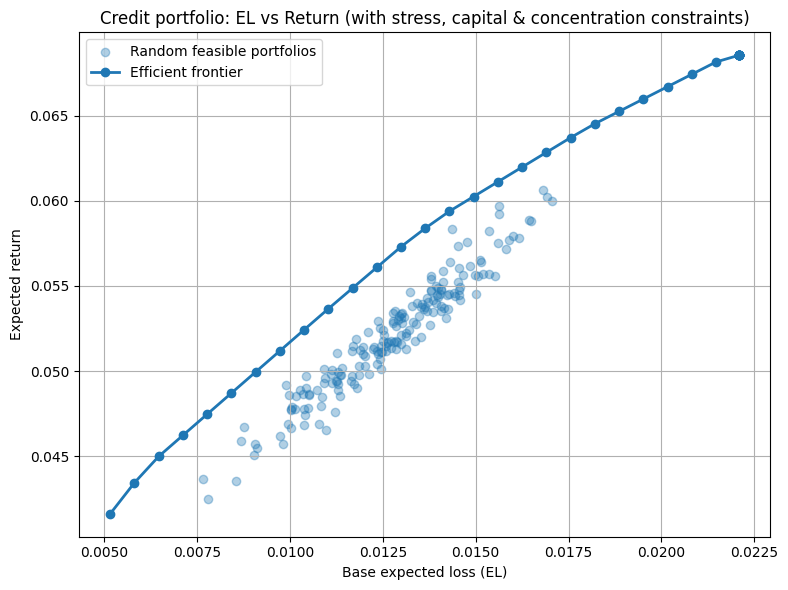


Most conservative efficient portfolio (lowest EL cap):


,segment,country,PD_base,PD_band,rw,weight
0,Seg_1,Country_B,0.022,Medium,0.581,0.100
1,Seg_2,Country_C,0.048,High,0.768,0.000
2,Seg_3,Country_A,0.038,Medium,0.792,0.000
3,Seg_4,Country_B,0.032,Medium,0.466,0.085
4,Seg_5,Country_A,0.012,Low,1.173,0.000
5,Seg_6,Country_A,0.012,Low,0.998,0.450
6,Seg_7,Country_B,0.008,Low,1.146,0.265
7,Seg_8,Country_C,0.044,High,1.105,0.100
8,Seg_9,Country_A,0.032,Medium,0.838,0.000
9,Seg_10,Country_B,0.037,Medium,1.130,0.000



Most aggressive efficient portfolio (highest EL cap):


,segment,country,PD_base,PD_band,rw,weight
0,Seg_1,Country_B,0.022,Medium,0.581,0.00
1,Seg_2,Country_C,0.048,High,0.768,0.40
2,Seg_3,Country_A,0.038,Medium,0.792,0.45
3,Seg_4,Country_B,0.032,Medium,0.466,0.00
4,Seg_5,Country_A,0.012,Low,1.173,0.00
5,Seg_6,Country_A,0.012,Low,0.998,0.00
6,Seg_7,Country_B,0.008,Low,1.146,0.00
7,Seg_8,Country_C,0.044,High,1.105,0.00
8,Seg_9,Country_A,0.032,Medium,0.838,0.00
9,Seg_10,Country_B,0.037,Medium,1.130,0.15


In [ ]:
# ------------------------------------------------------
# 6. Plot: random portfolios vs efficient frontier
# ------------------------------------------------------

plt.figure(figsize=(8, 6))
plt.scatter(random_EL, random_R, alpha=0.35, label="Random feasible portfolios")
plt.plot(frontier_EL, frontier_R, marker="o", linewidth=2, label="Efficient frontier")

plt.xlabel("Base expected loss (EL)")
plt.ylabel("Expected return")
plt.title("Credit portfolio: EL vs Return (with stress, capital & concentration constraints)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show extreme efficient portfolios
if len(frontier_weights) > 0:
    print("\nMost conservative efficient portfolio (lowest EL cap):")
    w_conservative = frontier_weights[0]
    display(pd.DataFrame({
        "segment": segments["segment"],
        "country": segments["country"],
        "PD_base": segments["PD_base"].round(3),
        "PD_band": segments["PD_band"],
        "rw": segments["rw"].round(3),
        "weight": np.round(w_conservative, 3),
    }))

    print("\nMost aggressive efficient portfolio (highest EL cap):")
    w_aggressive = frontier_weights[-1]
    display(pd.DataFrame({
        "segment": segments["segment"],
        "country": segments["country"],
        "PD_base": segments["PD_base"].round(3),
        "PD_band": segments["PD_band"],
        "rw": segments["rw"].round(3),
        "weight": np.round(w_aggressive, 3),
    }))
else:
    print("No frontier weights to display.")